# Backprojection of the Seismic Wavefield

In this notebook, we use the powerful deep neural network PhaseNet [Zhu et al. 2019](https://academic.oup.com/gji/article/216/1/261/5129142) to compute waveform features that are optimized for earthquake detection and location. The backprojection is done on these waveform features rather than the waveforms themselves. The efficient core backprojection routine used by `BPMF` is implemented in our python package [`beampower`](https://github.com/ebeauce/beampower). 

In [1]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import h5py as h5
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from BPMF.data_reader_examples import data_reader_mseed
from phasenet import wrapper as PN
from obspy import UTCDateTime as udt
from time import time as give_time
from scipy.signal import resample_poly

# this is necessary to limit the number of threads spawn by tf
os.environ["TF_NUM_INTRAOP_THREADS"] = str(n_CPUs)
os.environ["TF_NUM_INTEROP_THREADS"] = str(n_CPUs)
tf.config.threading.set_inter_op_parallelism_threads(n_CPUs)
tf.config.threading.set_intra_op_parallelism_threads(n_CPUs)
tf.config.set_soft_device_placement(True)

2023-03-07 10:07:30.934047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-07 10:07:30.934092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%config InlineBackend.figure_formats = ["svg"]

In [3]:
# PROGRAM PARAMETERS
# DEVICE: is "cpu" or "gpu" depending on whether you want to use Nvidia GPUs or not
DEVICE = "cpu"
# PHASES: list of seismic phases to use for backprojection
PHASES = ["P", "S"]
# N_MAX_STATIONS: the maximum number of stations used for stacking (e.g. the closest to a given grid point)
# note: this parameter is irrelevant in this example with only 8 stations, but it is important when
# using large seismic networks
N_MAX_STATIONS = 10

NETWORK_FILENAME = "network.csv"
TT_FILENAME = "tts.h5"
OUTPUT_DB_FILENAME = "raw_bp.h5"
DATA_FOLDER = "preprocessed_2_12"

# PhaseNet was trained for 100Hz data, however, it shows good performances
# for other sampling rates. Using 25Hz data causes PhaseNet to "smooth" in time 
# its output, which is actually good for the purpose of backprojection.
PHASENET_SAMPLING_RATE_HZ = 100.
UPSAMPLING_BEFORE_PN_DETECTION = 1
DOWNSAMPLING_BEFORE_PN_DETECTION = 1
UPSAMPLING_BEFORE_PN_RELOCATION = int(PHASENET_SAMPLING_RATE_HZ/BPMF.cfg.SAMPLING_RATE_HZ)
DOWNSAMPLING_BEFORE_PN_RELOCATION = 1
# Note for if you are adapting this tutorial to your data:
# UPSAMPLING_BEFORE_PN and DOWNSAMPLING_BEFORE_PN need to be integers
# if PHASENET_SAMPLING_RATE_HZ/BPMF.cfg.SAMPLING_RATE_HZ is not an integer,
# you need to find the closest integer that is a multiple of PHASENET_SAMPLING_RATE_HZ/BPMF.cfg.SAMPLING_RATE_HZ
# and choose DOWNSAMPLING_BEFORE_PN such that you fall back on PHASENET_SAMPLING_RATE_HZ after using resample_poly

## Load metadata

In [4]:
# load network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()
net.metadata

,station_id,networks,stations,longitude,latitude,elevation_m,depth_km
stations,,,,,,,
DD06,YH.DD06,YH,DD06,30.317770,40.623539,182.0,-0.182
SAUV,YH.SAUV,YH,SAUV,30.327200,40.740200,170.0,-0.170
DC06,YH.DC06,YH,DC06,30.265751,40.616718,555.0,-0.555
DC08,YH.DC08,YH,DC08,30.250130,40.744438,162.0,-0.162
SPNC,YH.SPNC,YH,SPNC,30.308300,40.686001,190.0,-0.190
DE08,YH.DE08,YH,DE08,30.406469,40.748562,31.0,-0.031
DC07,YH.DC07,YH,DC07,30.242170,40.667080,164.0,-0.164
DE07,YH.DE07,YH,DE07,30.411539,40.679661,40.0,-0.040


In [5]:
# load travel times and the grid point (source) coordinates
tts, source_coords = BPMF.utils.load_travel_times(
    os.path.join(BPMF.cfg.MOVEOUTS_PATH, TT_FILENAME),
    phases=PHASES,
    source_indexes=None,
    return_coords=True,
    stations=net.stations,
)

In [ ]:
# # uncomment this cell if you want to run the backprojection with the downsampled grid (if you ran the "bonus" section of the previous notebook!)
# sparse_grid_indexes = np.load(
#     os.path.join(BPMF.cfg.MOVEOUTS_PATH, f"sparse_grid_indexes_0.04.npy")
# )

# # load travel times and the grid point (source) coordinates
# tts, source_coords = BPMF.utils.load_travel_times(
#     os.path.join(BPMF.cfg.MOVEOUTS_PATH, TT_FILENAME),
#     phases=PHASES,
#     source_indexes=sparse_grid_indexes,
#     return_coords=True,
#     stations=net.stations,
# )

## Load the data

The following piece of code is written to process a single day, but you could loop over as many days as necessary.

In [6]:
date_list = net.datelist()
print("Days to process: ", date_list)

Days to process:  DatetimeIndex(['2012-07-07 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')


In [7]:
# this could be written as a loop:
#for date in date_list:
date = date_list[0]
date = pd.Timestamp(date)
date_str = date.strftime("%Y-%m-%d")
data_root_folder = os.path.join(BPMF.cfg.INPUT_PATH, str(date.year), date.strftime("%Y%m%d"))
t_start_day = give_time()
print(f"Reading data for {date_str}")
# -------------------------------------------
#            Load the data
# -------------------------------------------
data = BPMF.dataset.Data(
    date,
    data_root_folder,
    data_reader_mseed,
    duration=24.0 * 3600.0,
    sampling_rate=BPMF.cfg.SAMPLING_RATE_HZ,
)
data.read_waveforms(data_folder=DATA_FOLDER)
print(data.traces.__str__(extended=True))

Reading data for 2012-07-07
24 Trace(s) in Stream:
YH.DD06..BHN | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SAUV..HHN | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC06..BHE | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC08..BHE | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SPNC..BHE | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DE08..BHE | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SAUV..HHE | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC06..BHN | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SPNC..BHN | 2012-07-07T00:00:00.000000Z - 2012-07-08T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DE08..BHN | 2012-07-07T00:00:00.000000Z - 2012

In [8]:
# compute data availability
data.set_availability(net.stations)

## Compute the waveform features

The goal is to compute the `waveform_features` numpy.ndarray with dimension `(n_stations, n_channels, n_times)`.

Here, we demonstrate how a single-station deep neural network detector can be turned into an array detector with backprojection.

*Note:* we use `phasenet` from [https://github.com/ebeauce/PhaseNet](https://github.com/ebeauce/PhaseNet) to access the wrapper module `phasenet.wrapper`.

In [9]:
# get the data in a numpy.ndarray
data_arr = data.get_np_array(net.stations)

In [10]:
if ((UPSAMPLING_BEFORE_PN_DETECTION > 1) or (DOWNSAMPLING_BEFORE_PN_DETECTION > 1)):
    data_arr = resample_poly(
        data_arr,
        UPSAMPLING_BEFORE_PN_DETECTION,
        DOWNSAMPLING_BEFORE_PN_DETECTION,
        axis=-1
    )
# PN_probas are time series of P-/S-wave arrival probabilities
PN_probas, _ = PN.automatic_picking(
    data_arr[np.newaxis, ...],
    net.stations,
    mini_batch_size=16,
    format="ram",
    inter_op_parallelism_threads=n_CPUs,
    intra_op_parallelism_threads=n_CPUs,
)
waveform_features = np.swapaxes(PN_probas.squeeze(), 2, 1)
if ((UPSAMPLING_BEFORE_PN_DETECTION > 1) or (DOWNSAMPLING_BEFORE_PN_DETECTION > 1)):
    waveform_features = resample_poly(
        waveform_features,
        DOWNSAMPLING_BEFORE_PN_DETECTION,
        UPSAMPLING_BEFORE_PN_DETECTION,
        axis=-1
    )

n events: 1, n stations: 8, batch size (n events x n stations): 8


2023-03-07 10:07:47.420313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-07 10:07:47.420354: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 10:07:47.420380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hypo-7): /proc/driver/nvidia/version does not exist
2023-03-07 10:07:47.420724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 10:07:48.209620: I tensorflow/compiler/mlir/mlir_graph_optim

In [11]:
print("The shape of waveform_features is: ", waveform_features.shape)

The shape of waveform_features is:  (8, 2, 2160000)


Text(0.5, 0, 'Time (samples)')

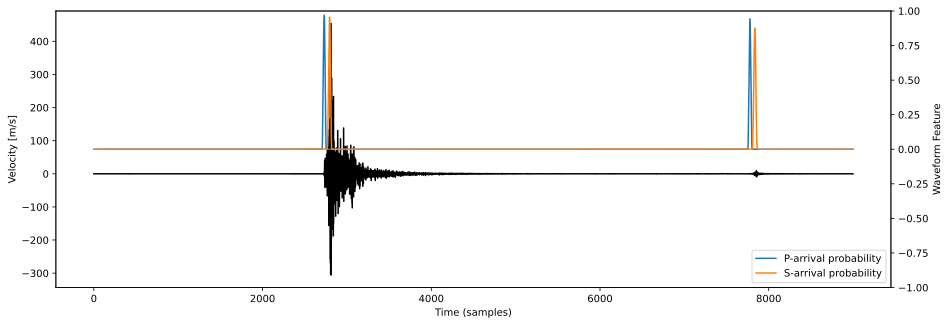

In [12]:
fig = plt.figure("waveform_feature", figsize=(15, 5))
idx1 = int(7.1*3600.*25.)
idx2 = int(7.2*3600.*25.)
ax = fig.add_subplot(111)
ax.plot(data_arr[0, 2, idx1:idx2], color="k")
ax.set_ylabel("Velocity [m/s]")
axb = ax.twinx()
axb.plot(waveform_features[0, 0, idx1:idx2], label="P-arrival probability")
axb.plot(waveform_features[0, 1, idx1:idx2], label="S-arrival probability")
axb.set_ylabel("Waveform Feature")
axb.set_ylim(-1., +1.0)
axb.legend(loc="lower right")

ax.set_xlabel("Time (samples)")

See that the number of channels in `waveform_features` is only 2. This is because `phasenet` returned a time series of P-arrival probability `waveform_features[:, 0, :]` and a time series of S-arrival probability `waveform_features[:, 1, :]`.

## Initialize the `Beamformer` instance

The initialization of the `Beamformer` instance only requires the table of travel times and the corresponding source coordinates. The sampling rate is used to convert the travel time table, in seconds, to a *moveout* table, in samples. Note that the moveouts are all taken relative to the first P-wave arrival for each source.

In [13]:
# the core attribute of the Beamformer instance is the table of travel times
bf = BPMF.template_search.Beamformer(
    tts,
    source_coords,
    sampling_rate=BPMF.cfg.SAMPLING_RATE_HZ,
    phases=PHASES,
)

## Inform the `Beamformer` instance of the data and metadata

Before using the `Beamformer` instance to backproject the wavefield, we need to set a number of important attributes to the instance. First, we attach the `Data` instance to the `Beamformer` instance so that `Beamformer`'s methods can read the `Data` instance's attributes. Second, we attach the `Network` instance corresponding to the set of stations that we are going to use for this backprojection.<br/>

**N.B.:** The `Network` instance can be a subset of the total network represented in the travel time table! It means that you can initialize the `Beamformer` instance once and for all and then process different time periods when the operating stations might be a subset of the total network.

In [14]:
# attach the Data instance
bf.set_data(data)
# attach the Network instance
bf.set_network(net)

## Define the phase-specific weights

We recall that the definition of a beam is:
$$ b_k(t) = \sum_{s, c, p} f_{s, c}(t + \tau_{s, p}^{(k)}),$$
where $k$ is the source (grid point) index, $f_{s, c}(t)$ is the waveform feature at station $s$, channel $c$ and time $t$, and $\tau_{s, p}^{(k)}$ is the moveout at station $s$, seismic phase $p$ and source $k$. For a given $p$, the moveout is the same of all channels of the same station $s$. Therefore, the quantity $\sum_{c} f_{s, c}(t)$ can be computed once and for all instead of re-computing it for each source.

However, for a given seismic phase, say the P-wave, we may not want to use all channels. For example, we may want to use only the vertical channel, or, with the `waveform_features` previously computed with `phasenet`, we only want to use the P-arrival probability time series. Thus, the quantity we can compute once and for all is:
$$ F_{s, p}(t) = \sum_{c} \alpha_{s, c, p} f_{s, c}(t).$$
$\alpha_{s, c, p}$ is the phase-specific weight at station $s$ and channel $c$ and for phase $p$.

In this example, the appropriate phase-specific weights are:
$$ w_{s, c=0, p=0} = 1;\quad w_{s, c=1, p=0} = 0,$$
$$ w_{s, c=0, p=1} = 0;\quad w_{s, c=1, p=1} = 1.$$

In [15]:
weights_phases = np.ones((waveform_features.shape[:-1]) + (2,), dtype=np.float32)
weights_phases[:, 0, 1] = 0.0  # S-wave weights to zero for channel 0
weights_phases[:, 1, 0] = 0.0  # P-wave weights to zero for channel 1
print("The shape of weights_phases is: ", weights_phases.shape)

The shape of weights_phases is:  (8, 2, 2)


In [16]:
# attach the phase-specific weights to the NetworkResponse instance
bf.set_weights(weights_phases=weights_phases)

## Define the source-specific weights

When using a grid covering a large geographical region, all stations may not be relevant to every source (grid point). Small earthquakes occurring at one end of the region are unlikely to be recorded by stations at the other end of the region. In order to only use the relevant data to each source, we define the source-specific weights $\beta_{k, s}$ and modify the definition of the beam:
$$ b_k(t) = \sum_{s, c, p} \beta_{k, s} \alpha_{s, c, p} f_{s, c}(t + \tau_{s, p}^{(k)}),$$
$$ b_k(t) = \sum_{s, p} \beta_{k, s} F_{s, p}(t + \tau_{s, p}^{(k)}).$$

The source-specific weights $\beta_{k, s}$ can be used to restrict the source-receiver distances included in the computation of $b_k(t)$, but also to downweight some stations. The default option in `BPMF` is to set to 0 all source-station weights beyond the `N_MAX_STATIONS` closest stations. In this example, we only have 8 stations and are studying a small region so all weights are 1.

In [17]:
bf.set_weights_sources(N_MAX_STATIONS)

## Run the backprojection

We are now ready to run the backprojection at all times $t$:
$$ b^*(t) = \underset{k}{\max} \lbrace b_k(t) \rbrace$$

$$ k^*(t) = \underset{k}{\argmax} \lbrace b_k(t) \rbrace $$

In [18]:
#
bf.backproject(waveform_features, device=DEVICE, reduce="max")

After calling `bf.backproject` with `reduce="max"`, we have computed $b^*(t)$ and $k^*(t)$. These can be found at `bf.maxbeam` and `bf.maxbeam_sources`.

Let's plot $b^*(t)$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


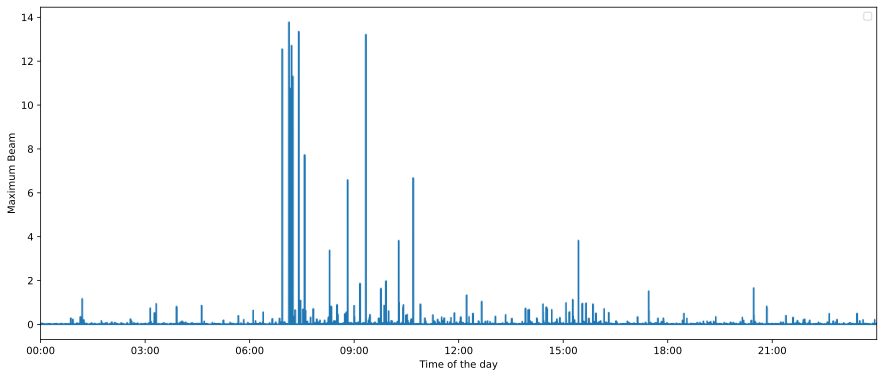

In [19]:
fig = bf.plot_maxbeam(figsize=(15, 6))
fig.set_facecolor("w")

## Define the earthquake detections

Detecting earthquakes based on the maximum beam computed above relies on a somewhat arbitrary task: defining a detection threshold. When stacking many time series, we may expect the sum to nearly be normally distributed according to the central limit theorem. However, the distribution of the maximum beam is often far from a normal distribution and the definition of a detection threshold based on gaussian p-values is not a valid approach.

The detection threshold used in this example was derived purely empirically by trial-and-error, checking the quality of the detected events. We use a threshold = 2. As you will see in the following cells, this choice is quite conservative; don't hesitate playing with the threshold and lowering it.

To avoid declaring multiple detections for a single event, we also define a minimum inter-event time. During the backprojection stage of `BPMF`, we do not aim at detecting all the closely occurring earthquakes of a single sequence but solely need to detect some of these earthquakes that will later allow detecting the whole sequence with template matching. Thus, we choose a minimum inter-event time of 1 minute.

In [20]:
MINIMUM_INTEREVENT_TIME_SEC = 60.0  
detection_threshold = 2.00 * np.ones(len(bf.maxbeam), dtype=np.float32)

detections, peak_indexes, source_indexes = bf.find_detections(
    detection_threshold, MINIMUM_INTEREVENT_TIME_SEC
)

Extracted 13 events.


Let's see which peaks resulted in earthquake detections.

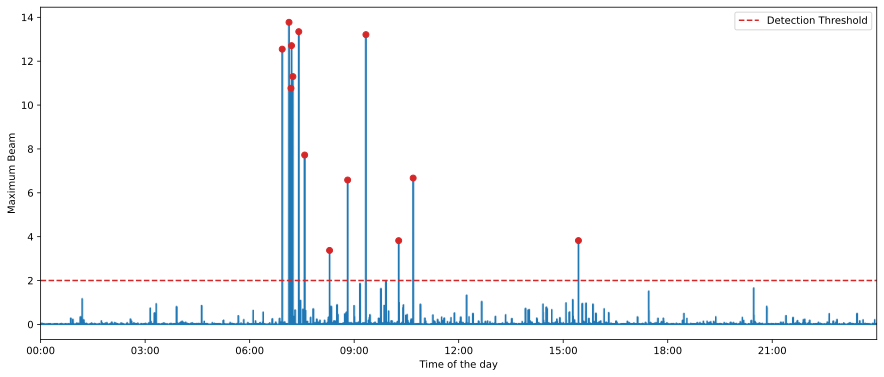

In [21]:
fig = bf.plot_maxbeam(figsize=(15, 6))
fig.set_facecolor("w")

At this stage, we could save the metadata of each detected event and go to the next notebook, but we will first look at the waveforms of the detected events.

## Extract the detected events from the continuous data

Each detected earthquake is returned as an instance of the `BPMF.dataset.Event` class.

In [22]:
# event extraction parameters

# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 1.0, "S": 4.0}
# TIME_SHIFTED: boolean, if True, use moveouts to extract relevant windows
TIME_SHIFTED = True

t1 = give_time()
for i in range(len(detections)):
    detections[i].read_waveforms(
        BPMF.cfg.TEMPLATE_LEN_SEC,
        phase_on_comp=PHASE_ON_COMP,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
    )
t2 = give_time()
print(
    f"{t2-t1:.2f}sec to read the waveforms for all {len(detections):d} detections."
)

2.99sec to read the waveforms for all 13 detections.


In the following, we use the `Beamformer` method to plot the detected earthquakes (only works after calling `read_waveform` with each detection, see above cell). Because we declared in `PHASE_ON_COMP` using the S wave on the horizontal components and the P wave on the vertical components, the red vertical lines on the following plots show the predicted S-wave arrival on the horizontal components and the P-wave arrival on the vertical components.

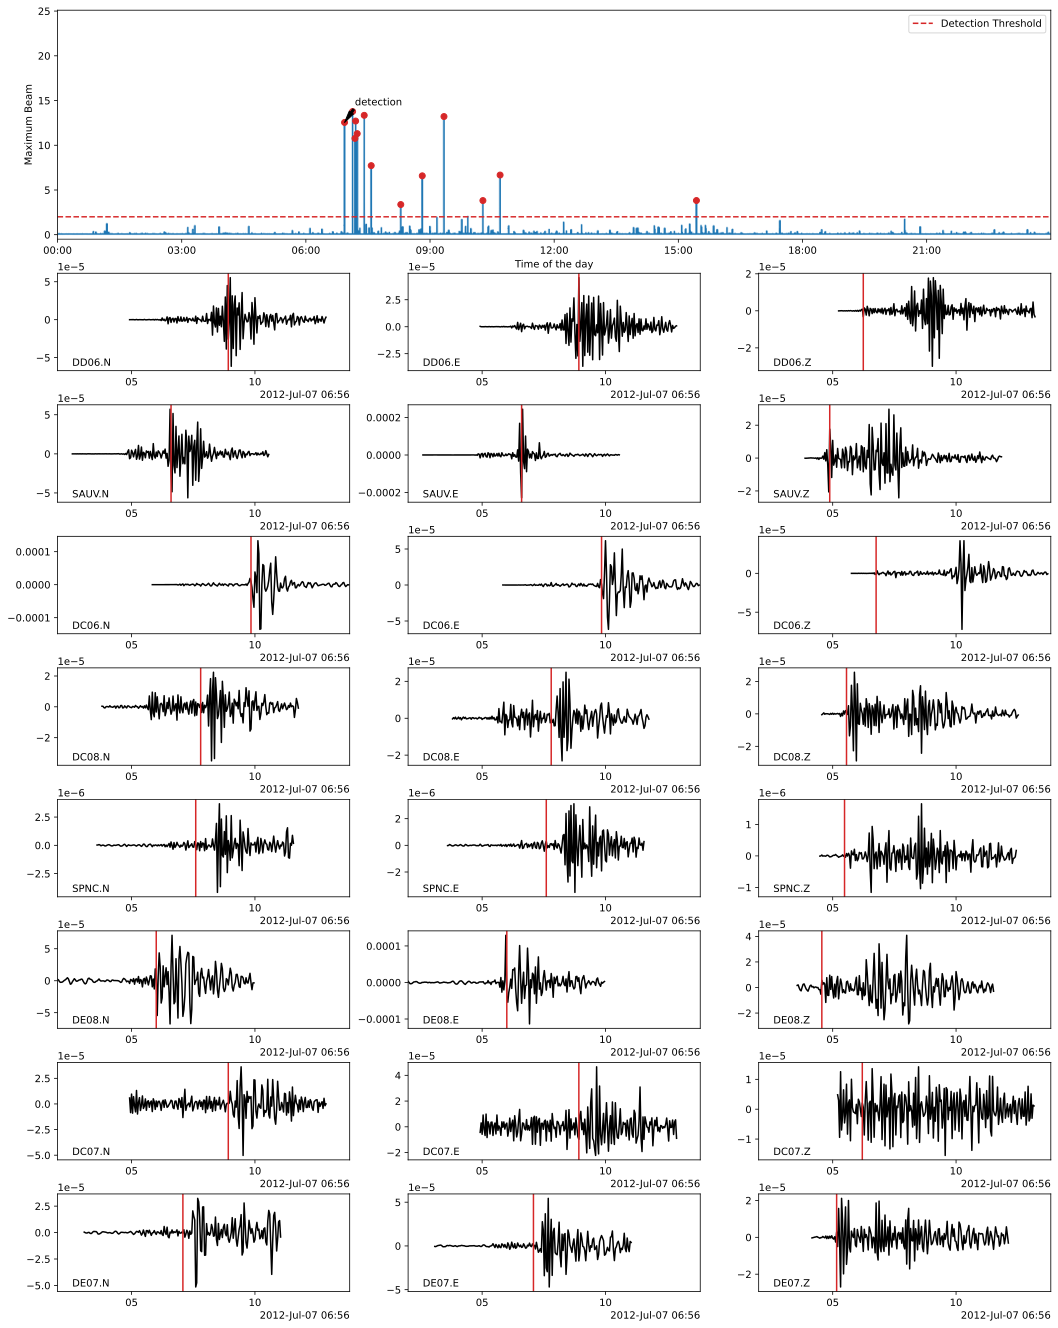

In [23]:
fig = bf.plot_detection(detections[0], figsize=(15, 20))
fig.set_facecolor("w")

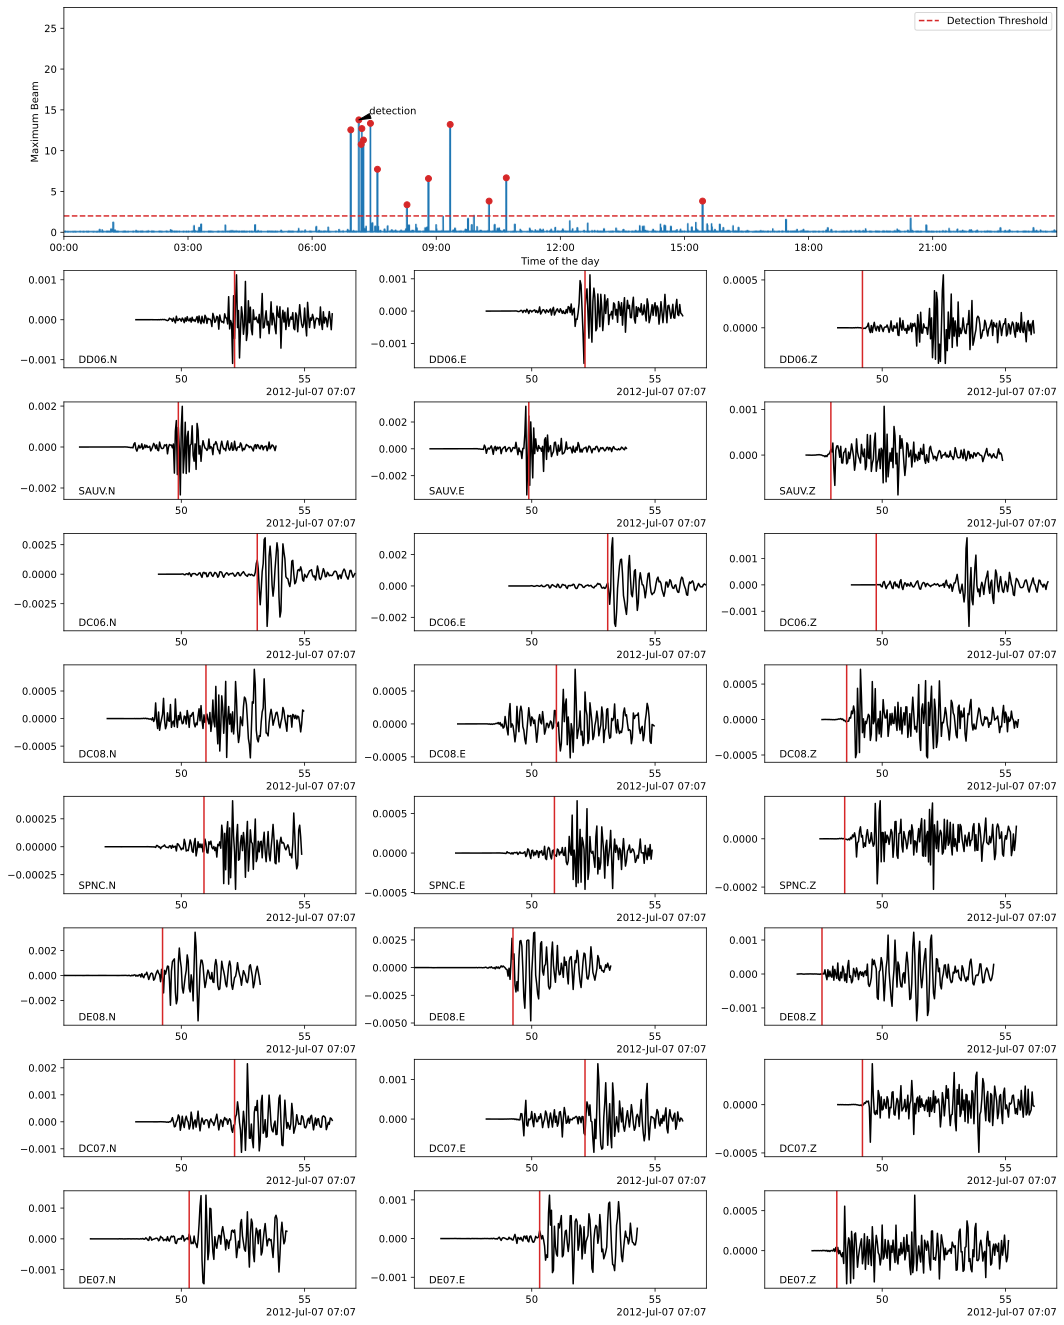

In [25]:
fig = bf.plot_detection(detections[1], figsize=(15, 20))
fig.set_facecolor("w")

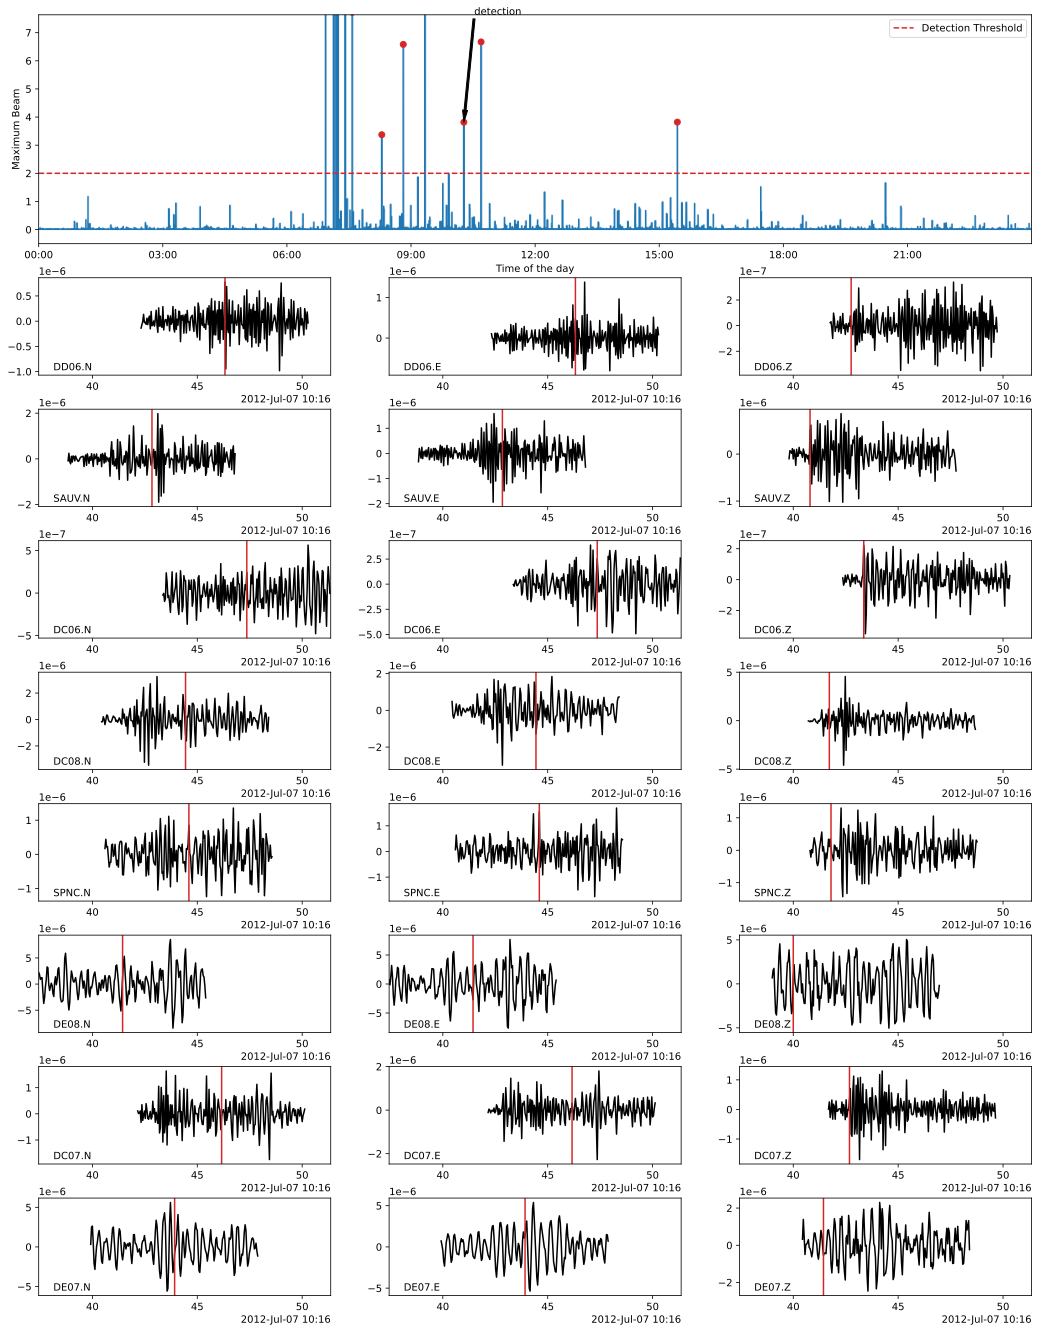

In [24]:
fig = bf.plot_detection(detections[10], figsize=(15, 20))
fig.set_facecolor("w")

## Store the metadata of the detected earthquakes in a database

By calling the `Event.write` method for each detection, we save their metadata in a hdf5 file located at `BPMF.cfg.OUTPUT_PATH/OUTPUT_DB_FILENAME`. Each event is stored in a separate hdf5 group with name defined as `detections[i].id`.

In [26]:
# ---------------------------------------------------------
#                 Save detections
# ---------------------------------------------------------
for i in range(len(detections)):
    detections[i].write(
        OUTPUT_DB_FILENAME,
        db_path=BPMF.cfg.OUTPUT_PATH,
        gid=detections[i].id
        )